# 6.4

## 과대적합
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

In [9]:
# Overfitting 예시

import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from optimizer import SGD
from multi_layer_net import MultiLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 과대적합을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size = 784, hidden_size_list=[100,100,100,100,100,100], output_size = 10)
optimizer = SGD(lr=0.01)
max_epochs = 201

epoch:0, train acc:0.08333333333333333, test acc:0.0765
epoch:1, train acc:0.07333333333333333, test acc:0.0802
epoch:2, train acc:0.09, test acc:0.0851
epoch:3, train acc:0.1, test acc:0.0895
epoch:4, train acc:0.12666666666666668, test acc:0.0965
epoch:5, train acc:0.14333333333333334, test acc:0.1048
epoch:6, train acc:0.15333333333333332, test acc:0.1143
epoch:7, train acc:0.17333333333333334, test acc:0.1248
epoch:8, train acc:0.20333333333333334, test acc:0.1396
epoch:9, train acc:0.22333333333333333, test acc:0.1554
epoch:10, train acc:0.25, test acc:0.1755
epoch:11, train acc:0.27, test acc:0.1951
epoch:12, train acc:0.31666666666666665, test acc:0.2134
epoch:13, train acc:0.3333333333333333, test acc:0.2246
epoch:14, train acc:0.3466666666666667, test acc:0.239
epoch:15, train acc:0.37333333333333335, test acc:0.2586
epoch:16, train acc:0.4066666666666667, test acc:0.2787
epoch:17, train acc:0.42, test acc:0.2902
epoch:18, train acc:0.4633333333333333, test acc:0.3141
epoch:19

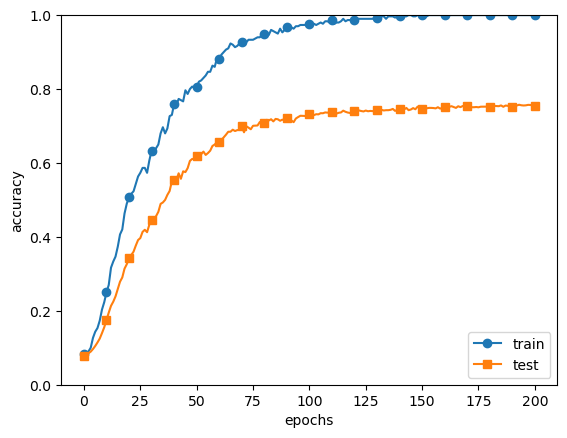

In [8]:
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 가중치 감소
과적합은 매개변수의 값이 크면 입력이 바뀌었을 때, 민감하게 반응하기 때문에 과적합이 발생한다.<br>
가중치 각각의 손실함수에 $1/2*λ * W^2$를 더해서 큰 가중치에 패널티를 부과한다.

### 드롭아웃
train할 때는 한 번의 순전파마다 삭제할 뉴런을 랜덤하게 선정해서 학습하고 test에서는 모든 뉴런에 데이터를 흘린다. 단, 각 뉴런의 출력에 train에서 삭제 안 한 비율을 곱해서 출력한다.

In [10]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_fig = True):
        if train_fig:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x*self.mask

        else:
            return x*(1.0-self.dropout_ratio)

    def backward(self, dout):
        return dout*self.mask

Dropout은 순전파마다 다른 신경망의 구조인 셈이므로 여러 신경망을 준비해서 출력의 평균을 내는 **앙상블 학습**과 유사하다.<br>

# 6.5 적절한 하이퍼파라미터 값 찾기

## 검증 데이터(validation data)
하이퍼파라미터의 조정을 위해 train data의 일부를 사용. 단, test data를 사용하지 않도록 조심해야한다.

In [14]:
(x_train, t_train), (x_test, t_test) = load_mnist()
# shuffle the train data
# x_train, t_train = shuffle_dataset(x_train, t_train)

# split train data 20% -> validation data
validation_rate = 0.20
validation_num = int(x_train.shape[0]*validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

0. 하이퍼파라미터 값의 범위 설정
1. 설정된 범위에서 하이퍼파라미터 값을 무작위 추출
2. 해당 값으로 검증 데이터에서 정확도 평가
3. 1,2단계 반복 -> 하이퍼파라미터의 범위를 좁혀나가기